# HDA - Project 3

In [5]:
import utils
import deeplearning
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from keras import regularizers
from keras.activations import relu
from keras.layers import Conv2D, BatchNormalization, Dropout, LeakyReLU, Flatten, Activation, Dense, MaxPooling2D, LSTM, Reshape
from keras.models import load_model, Model, Sequential
from keras.optimizers import Adam

The following cell contains the hyper-parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: column of features to be selected to perform activity detection, between [0,6]:

|  Label |  Feature |
|:-:     |:-:|
|  0     | Locomotion (TASK A)  |
|  1     | High Level Activity |
|  2     | Low Level Left Arm  |
|  3     | Low Level Left Arm Object  |
|  4     | Low Level Right Arm  |
|  5     | Low Level Right Arm Object  |
|  6     | Medium Level Both Arms (TASK B2) |

- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

The size of the temporal window seems to be fundamental in order to get a more specific and powerful model; of course the choice of the step lenght between consequent windows has to be consistent and to make sense. Thinking about a real-time situation, as long as we collect data we can use a sliding window of real-time samples; in this way, it is reasonable to use also a small value for the stride. Another important reason behind the choice of the value of the 

In [6]:
subject = 2
#folder = "./data/full/"
folder = "/floyd/input/hdadataset/full/" # To be used with FloydHub
label = 0     # default for task A
window_size = 64
stride = 3
C = [2**(-6)]

Let's load the models: 

In [7]:
start = time.time()
detection_model = load_model('./data/detection_model_A.h5')
end = time.time()
print("Time to load the detection model: %.3f s" % (end - start))

start = time.time()
classification_model = load_model('./data/classification_model_A.h5')
end = time.time()
print("Time to load the classification model: %.3f s" % (end - start))

Time to load the detection model: 3.485 s
Time to load the classification model: 4.966 s


# USER 1
### Detection

In [8]:
[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(1,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    make_binary = True)

Training samples:  157125 
Test samples:       57536 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (52354, 64, 110) 
Dataset of Labels have shape:    (52354, 2) 
Fraction of labels:   [0.10986744 0.89013256]
TEST SET:
Dataset of Images have shape:  (19157, 64, 110) 
Dataset of Labels have shape:    (19157, 2) 
Fraction of labels:   [0.17737642 0.82262358]


In [9]:
n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 2

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = detection_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

Time to evaluate predictions: 19.800


Accuracy:  0.9232656470219763
F1-measure:  0.915635003127542


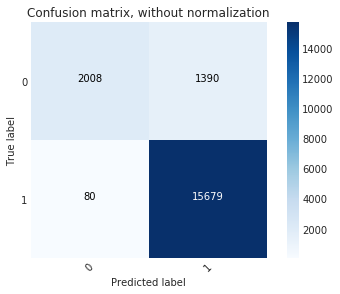

In [10]:
print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

### Classification

In [11]:
[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(1,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    null_class = False)

Training samples:  157125 
Test samples:       57536 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (46601, 64, 110) 
Dataset of Labels have shape:    (46601, 4) 
Fraction of labels:   [0.47 0.31 0.19 0.03]
TEST SET:
Dataset of Images have shape:  (15758, 64, 110) 
Dataset of Labels have shape:    (15758, 4) 
Fraction of labels:   [0.42 0.25 0.29 0.05]


In [12]:
n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 4

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = classification_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

Time to evaluate predictions: 28.392


Accuracy:  0.8768879299403478
F1-measure:  0.8562803260042464


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


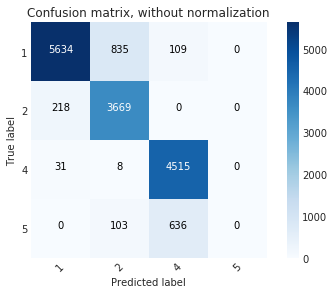

In [13]:
# Performances

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

In [18]:
# SVM Feature Extraction

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
[trainingFeatures, testingFeatures] = deeplearning.extractFeatures(classification_model,
                                                                   input_train,
                                                                   input_test,
                                                                   classification_model.layers[-1].output_shape[1],
                                                                   batchSize = 300)
# SVM Prediction

output_train = np.argmax(y_train, axis=1)
prediction_svm = deeplearning.SVMLayer(C,
                                        output_train,
                                        trainingFeatures,
                                        testingFeatures) 

TRAINING:   0%|                                                             | 0/156 [00:00<?, ?it/s]

Computing DNN features on the training set...


TESTING:   0%|                                                               | 0/53 [00:00<?, ?it/s]

Computing DNN features on the testing set...


TESTING: 100%|######################################################| 53/53 [00:16<00:00,  3.22it/s]

Training the model with C = 0.0156 ...


Accuracy with SVM:  0.8806955197360071
F1-measure with SVM:  0.8598629000728439


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


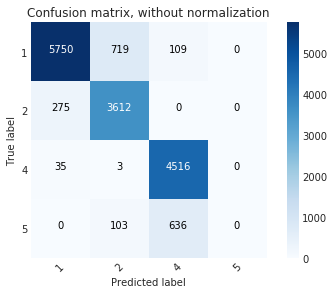

In [20]:
# Performances with SVM

print("Accuracy with SVM: ", accuracy_score(np.argmax(y_test, axis=1), prediction_svm))
print("F1-measure with SVM: ", utils.f1_score(np.argmax(y_test, axis=1), prediction_svm, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction_svm)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

# USER 2

In [ ]:
# Detection

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(2,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    make_binary = True)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 2

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = detection_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [ ]:
# Classification

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(2,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    null_class = False)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 4

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = classification_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

In [ ]:
# SVM Feature Extraction

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
[trainingFeatures, testingFeatures] = deeplearning.extractFeatures(classification_model,
                                                                   input_train,
                                                                   input_test,
                                                                   classification_model.layers[-1].output_shape[1],
                                                                   batchSize = 300)
# SVM Prediction

output_train = np.argmax(y_train, axis=1)
prediction_svm = deeplearning.SVMLayer(C,
                                        output_train,
                                        trainingFeatures,
                                        testingFeatures) 

# Performances with SVM

print("Accuracy with SVM: ", accuracy_score(np.argmax(y_test, axis=1), prediction_svm))
print("F1-measure with SVM: ", utils.f1_score(np.argmax(y_test, axis=1), prediction_svm, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction_svm)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

# USER 3

In [ ]:
# Detection

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(3,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    make_binary = True)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 2

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = detection_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [ ]:
# Classification

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(3,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    null_class = False)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 4

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = classification_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

In [ ]:
# SVM Feature Extraction

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
[trainingFeatures, testingFeatures] = deeplearning.extractFeatures(classification_model,
                                                                   input_train,
                                                                   input_test,
                                                                   classification_model.layers[-1].output_shape[1],
                                                                   batchSize = 300)
# SVM Prediction

output_train = np.argmax(y_train, axis=1)
prediction_svm = deeplearning.SVMLayer(C,
                                        output_train,
                                        trainingFeatures,
                                        testingFeatures) 

# Performances with SVM

print("Accuracy with SVM: ", accuracy_score(np.argmax(y_test, axis=1), prediction_svm))
print("F1-measure with SVM: ", utils.f1_score(np.argmax(y_test, axis=1), prediction_svm, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction_svm)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

# USER 4

In [ ]:
# Detection

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(4,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    make_binary = True)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 2

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = detection_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [ ]:
# Classification

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(4,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    null_class = False)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 4

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = classification_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

In [ ]:
# SVM Feature Extraction

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
[trainingFeatures, testingFeatures] = deeplearning.extractFeatures(classification_model,
                                                                   input_train,
                                                                   input_test,
                                                                   classification_model.layers[-1].output_shape[1],
                                                                   batchSize = 300)
# SVM Prediction

output_train = np.argmax(y_train, axis=1)
prediction_svm = deeplearning.SVMLayer(C,
                                        output_train,
                                        trainingFeatures,
                                        testingFeatures) 

# Performances with SVM

print("Accuracy with SVM: ", accuracy_score(np.argmax(y_test, axis=1), prediction_svm))
print("F1-measure with SVM: ", utils.f1_score(np.argmax(y_test, axis=1), prediction_svm, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction_svm)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')